In [299]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection  import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

In [300]:
df = pd.read_csv('all_data.csv')
y = df['beat_spread']
X = df.copy()
X.pop('beat_spread')
X.pop('date')
X.pop('Unnamed: 0')

0        0
1        1
2        2
3        3
4        4
        ..
9871    68
9872    69
9873    70
9874    71
9875    72
Name: Unnamed: 0, Length: 9876, dtype: int64

In [301]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3)

# Models Being Considered

For this binary classification class, I am deciding between a Random Forest Classifier, LightGBM, LinearSVC, and Neural Net with only one layer of neurons.

In [302]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

In [303]:
def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(10, input_dim=10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    #Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [309]:
# make predictions using random forest for classification
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold 
from sklearn.svm import LinearSVC
from lightgbm import LGBMClassifier


kf = KFold(n_splits=5, shuffle = True, random_state=None)



print(kf.split(X))

metrics = {'accuracy':[], 'f1': []}

for train_index, test_index in kf.split(X):
    #print(train_index, test_index)
    X_train, X_test = X.values[train_index], X.values[test_index] 
    y_train, y_test = y.values[train_index], y.values[test_index]
    model = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=0)
    model.fit(X_train, y_train)
    
    rfc_pred_test = model.predict(X_test)
    f1_test = f1_score(y_test,rfc_pred_test)
    accuracy_test = accuracy_score(y_test, rfc_pred_test)

    metrics['accuracy'].append(accuracy_test)
    metrics['f1'].append(f1_test)

accuracy = np.array(metrics['accuracy'])
f1 = np.array(metrics['f1'])


accuracy_avg = accuracy.mean()*100
accuracy_std = accuracy.std()*100

f1_avg = f1.mean()*100
f1_std = f1.std()*100
    
print("Accuracy: %.2f%% (%.2f%%)" % (accuracy_avg, accuracy_std))
print("F1: %.2f%% (%.2f%%)" % (f1_avg, f1_std))


<generator object _BaseKFold.split at 0x170a54b30>


KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.


KeyboardInterrupt: 

# Results
avg (std)
### RandomForestClassifier(n_estimators = 1000)
Accuracy: 69.02% (0.63%)
F1: 68.13% (0.62%)

### LinearSVC()
Accuracy: 58.63% (1.53%)
F1: 59.69% (15.04%)

### LGBMClassifier(n_estimators = 50)
Accuracy: 70.55% (0.89%)
F1: 69.75% (0.85%)

### KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=0)
Accuracy: 65.34% (0.82%)
F1: 61.65% (3.93%)


Because of the fast training time, high accuracy, and low standard deviation, I chose the **LGBM Classifier**

# Finding the Optimal Betting Strategy

With the LGBM model, I now want to figure out which games to bet on. How sure does my model have to be in the outcome of its prediction for me to make a bet (either that the team does or doesn't beat the spread). Note that generally you have to bet 110 to win 100 in Vegas

In [325]:
# Penalty for incorrect bet -1.1
# Benefit for correct bet +1
#We want to find the optimal threshold of confidence for our model to make a bet
def calibrate_thresholds():
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2)
    model = LGBMClassifier(n_estimators = 50)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    probabilities = model.predict_proba(X_test)

    metrics = {}
    metrics['thresholds'] = np.linspace(0.5,1, num = 100)
    metrics['money_made'] = []
    metrics['ROIs'] = []
    metrics['certainty'] = []
    metrics['lowests'] = []
    metrics['money_per_bet'] = []
    metrics['percent_of_games_bet'] = [] #how many games are there to bet on

    
    for threshold in thresholds:
        money = 0
        correct = 0
        total = 0
        lowest = 110
        totalmoney = 0
        number_of_games = 0
        for i in range(len(predictions)):
            number_of_games+=1
            prediction = predictions[i]
            probability_tup = probabilities[i]
            if abs(probability_tup[0]-0.5)>abs(threshold-0.5):
                #works if threshold is greater than 0.5, which it has to be
                #print(probability_tup, threshold, prediction)
                if prediction == y_test.iloc[i]:
                    correct+=1
                    money += 210
                else:
                    money-=0
                total+=1
                totalmoney+=110
                
                lowest = min(lowest, money-totalmoney)
        metrics['percent_of_games_bet'].append(100*total/number_of_games)
        metrics['money_made'].append(money-totalmoney)
        metrics['lowests'].append(lowest)
        if total == 0:
            metrics['certainty'].append(0)
            metrics['ROIs'].append(1)
            metrics['money_per_bet'].append(0)
        else:
            ROI = money/totalmoney
            metrics['certainty'].append(correct/total)
            metrics['ROIs'].append(ROI)
            metrics['money_per_bet'].append((money-totalmoney)/total)
    return metrics



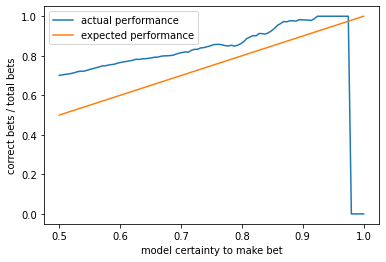

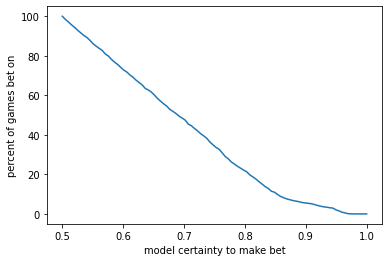

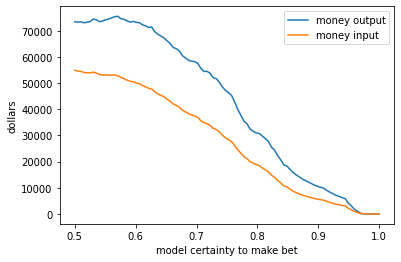

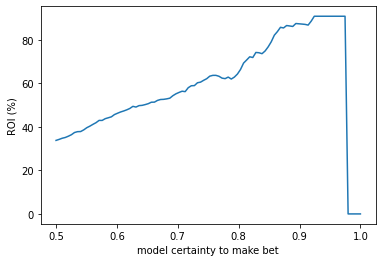

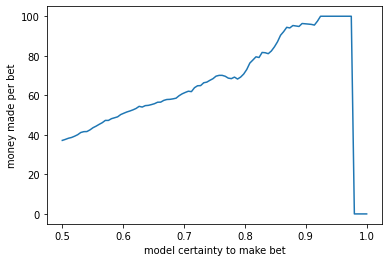

In [326]:
metrics = calibrate_thresholds()

#print(certainty)

plt.figure(0)
plt.plot(metrics['thresholds'],metrics['certainty'], label = 'actual performance')
plt.xlabel('model certainty to make bet')
plt.ylabel('correct bets / total bets')
plt.plot(metrics['thresholds'], metrics['thresholds'], label = 'expected performance')
plt.legend()

plt.figure(1)
plt.plot(metrics['thresholds'],metrics['percent_of_games_bet'])
plt.xlabel('model certainty to make bet')
plt.ylabel('percent of games bet on')

plt.figure(2)
plt.plot(metrics['thresholds'],metrics['money_made'], label = 'money output')
plt.xlabel('model certainty to make bet')
plt.ylabel('dollars')
plt.plot(metrics['thresholds'], [metrics['money_made'][i]/metrics['ROIs'][i] for i in range(len(metrics['money_made']))], 
         label = 'money input')
plt.legend()

plt.figure(3)
plt.plot(metrics['thresholds'],100*np.array(metrics['ROIs'])-100)
plt.xlabel('model certainty to make bet')
plt.ylabel('ROI (%)')

plt.figure(4)
plt.plot(metrics['thresholds'],metrics['money_per_bet'])
plt.xlabel('model certainty to make bet')
plt.ylabel('money made per bet')


plt.show()

In [328]:



to_calibrate_quants = ['money_per_bet', 'ROIs', 'money_made']

for to_calibrate in to_calibrate_quants:
    result_cal = {}                       
    names = []
    for i in range(50):
        metrics = calibrate_thresholds()
        names = list(metrics.keys())

        max_cal = max(metrics[to_calibrate])
        index = metrics[to_calibrate].index(max_cal)

        for name in names:
            if i == 0:
                result_cal[name] = []
            result_cal[name].append(metrics[name][index])

    for name in names:
        quality = np.array(result_cal[name])
        print(name+": %.2f (%.2f)" % (np.mean(quality), np.std(quality)))
    print('\n')


# with this formulation of the problem, it is clear that we shou
    

thresholds: 0.94 (0.02)
money_made: 5132.00 (1950.33)
ROIs: 1.91 (0.00)
certainty: 1.00 (0.00)
lowests: 100.00 (0.00)
money_per_bet: 100.00 (0.00)
percent_of_games_bet: 2.60 (0.99)


thresholds: 0.94 (0.02)
money_made: 4864.00 (2231.57)
ROIs: 1.91 (0.00)
certainty: 1.00 (0.00)
lowests: 100.00 (0.00)
money_per_bet: 100.00 (0.00)
percent_of_games_bet: 2.46 (1.13)


thresholds: 0.53 (0.02)
money_made: 75562.20 (4712.63)
ROIs: 1.38 (0.03)
certainty: 0.72 (0.02)
lowests: -49.60 (157.16)
money_per_bet: 41.41 (3.73)
percent_of_games_bet: 92.78 (6.62)




We maximize our profits when we set our threshold to 0.53

thresholds: 0.53 (0.02)
money_made: 53614.84 (3385.73)
ROIs: 1.30 (0.03)
certainty: 0.68 (0.02)
totalbets: 1625.75 (148.72)
lowests: -84.00 (202.87)
money_per_bet: 33.21 (3.26)

We make a ton of money ($50k), but we also make a ton of bets. Our average profit per bet is only 31.12 (2.43). The reason this threshold is so low is because our system is less sure of itself than it should be. It's right way more often than it's given probability.


We maximize our ROI and money made per bet when we set the threshold to 0.92

thresholds: 0.92 (0.02)
money_made: 3310.78 (1327.49)
ROIs: 1.91 (0.00)
certainty: 1.00 (0.00)
totalbets: 33.11 (13.27)
lowests: 100.00 (0.00)
money_per_bet: 99.98 (0.34)

We now make less money (3410 with a big swing), but our return on investment is 1.91 with little deviation. We make 100 bucks per bet, which is pretty great. Our ROI is solid at 1.91
